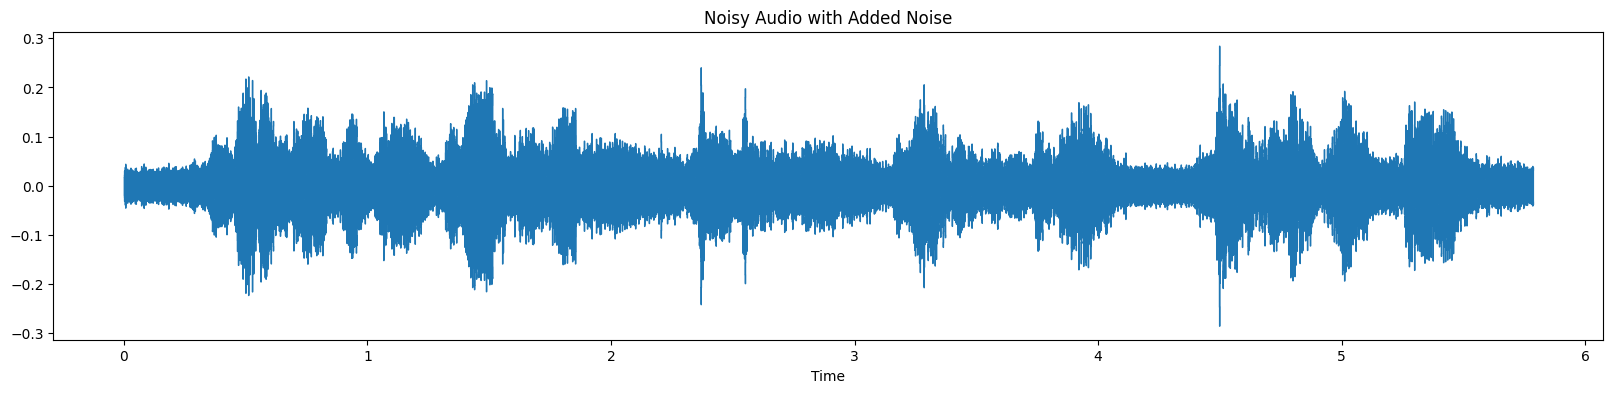

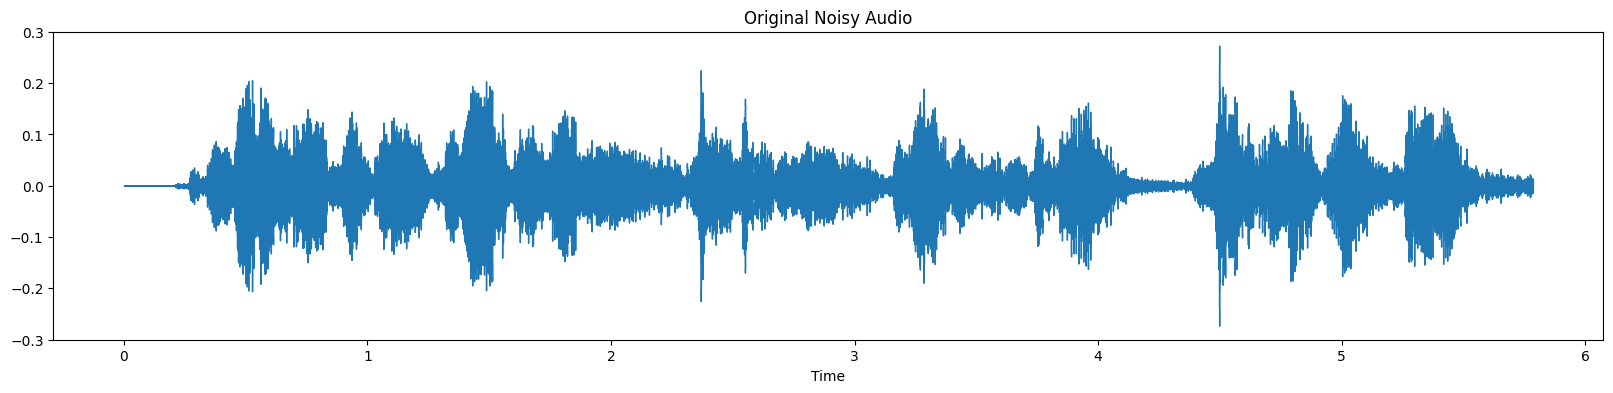

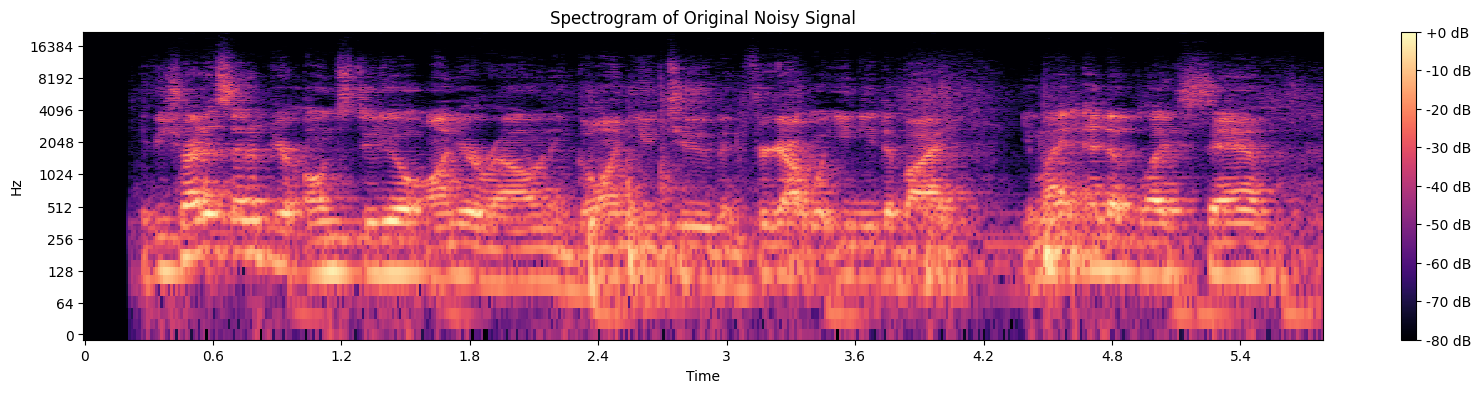

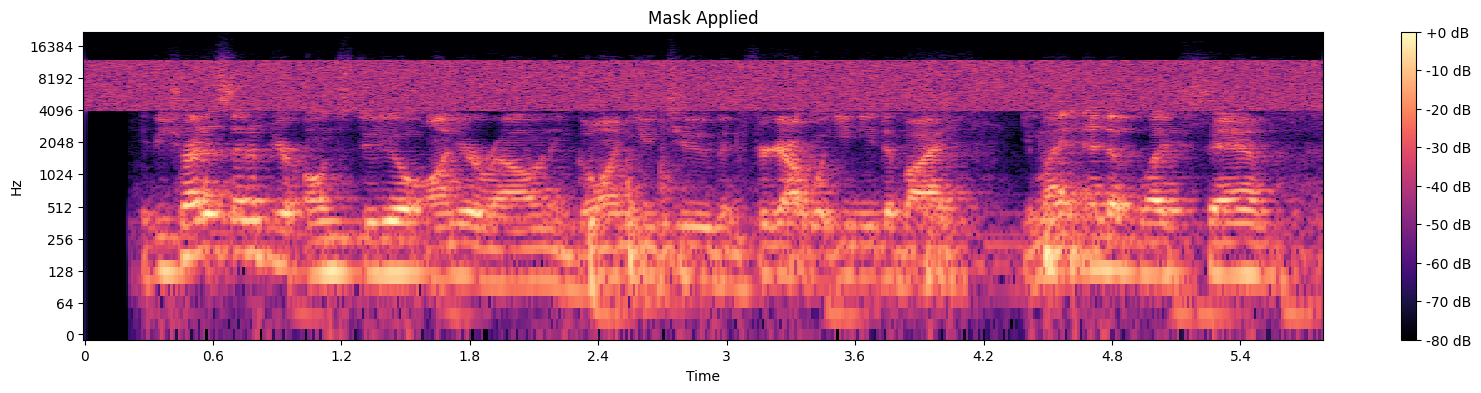

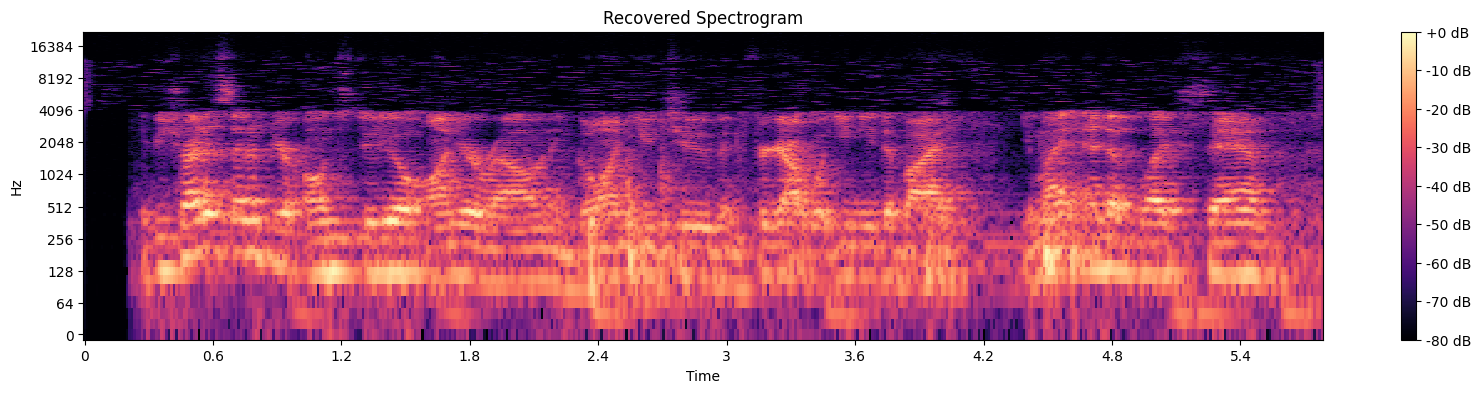

Original Noisy Audio:


Enhanced Audio:


In [3]:
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import librosa
import librosa.display
from datetime import timedelta as td
import time
from pedalboard.io import AudioFile
from pedalboard import *
import noisereduce as nr

def read_audio(filename, sr=None):
    data, rate = librosa.load(filename, sr=sr)
    return rate, data.astype(np.float32)  # Convert to floating-point

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)

def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real

def plot_audio(signal, title):
    plt.figure(figsize=(20, 4))
    librosa.display.waveshow(signal, sr=rate)
    plt.title(title)
    plt.show()

def plot_spectrogram(signal, title):
    plt.figure(figsize=(20, 4))
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(signal), ref=np.max), sr=rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)

def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length=hop_length, win_length=win_length)

def _db_to_amp(x):
    return 10.0**(x / 20.0)

def remove_noise(audio_clip, noise_clip, n_grad_freq=2, n_grad_time=4, n_fft=2048, win_length=2048, hop_length=512, n_std_thresh=1.5, prop_decrease=1.0, verbose=False, visual=False):
    if verbose:
        start = time.time()
    
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    
    smoothing_filter = np.outer(np.concatenate([np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                                                 np.linspace(1, 0, n_grad_freq + 2)]),
                                 np.concatenate([np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                                                 np.linspace(1, 0, n_grad_time + 2)]))
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    
    db_thresh = np.repeat(np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
                          np.shape(sig_stft_db)[1], axis=0).T
    
    sig_mask = sig_stft_db < db_thresh
    
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    
    sig_stft_db_masked = (sig_stft_db * (1 - sig_mask) +
                          np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask)
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (1j * sig_imag_masked)
    
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    
    return recovered_signal

# Load noisy audio data
audio_loc = "./audios/audio3.wav"  # Change to your MP3 file path
rate, data = read_audio(audio_loc, sr=44100)  # Set sampling rate if known, otherwise, remove 'sr' argument

# Plot original noisy audio


# Generate noise and add it to the original audio
noise_len = len(data) / rate
noise = band_limited_noise(min_freq=4000, max_freq=12000, samples=len(data), samplerate=rate) * 10
audio_clip_band_limited = data + noise

# Plot audio with added noise
plot_audio(audio_clip_band_limited, "Noisy Audio with Added Noise")
plot_audio(data, "Original Noisy Audio")
# Remove noise from audio
recovered_signal = remove_noise(audio_clip_band_limited, noise)

# Plot spectrograms of original noisy signal, mask applied, and recovered signal
spec_original = _stft(data, n_fft=2048, hop_length=512, win_length=2048)
spec_mask = _stft(audio_clip_band_limited, n_fft=2048, hop_length=512, win_length=2048)
spec_recovered = _stft(recovered_signal, n_fft=2048, hop_length=512, win_length=2048)

plot_spectrogram(spec_original, "Spectrogram of Original Noisy Signal")
plot_spectrogram(spec_mask, "Mask Applied")
plot_spectrogram(spec_recovered, "Recovered Spectrogram")

# Display original noisy audio and recovered audio
print("Original Noisy Audio:")
ipd.display(ipd.Audio(data, rate=rate))
#noise reduction using pedalboard
from pedalboard.io import AudioFile
from pedalboard import *
import noisereduce as nr

sr=44100
with AudioFile('./audios/audio3.wav').resampled_to(sr) as f:
  audio = f.read(f.frames)

reduced_noise = nr.reduce_noise(y=audio, sr=sr, stationary=True, prop_decrease=0.75)

board = Pedalboard([
    NoiseGate(threshold_db=-30, ratio=1.5, release_ms=250),
    Compressor(threshold_db=-16, ratio=2.5),
    LowShelfFilter(cutoff_frequency_hz=400, gain_db=10, q=1),
    Gain(gain_db=10)
])

effected = board(reduced_noise, sr)


with AudioFile('./audios/enhenced_audio3.wav', 'w', sr, effected.shape[0]) as f:
  f.write(effected)
print("Enhanced Audio:")
enhanced_audio = "./audios/enhenced_audio3.wav"
ipd.display(ipd.Audio(enhanced_audio))

